# <center>Actual sales forecast exercise</center>

### <center>Author: Adriana Vega</center>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.tsa.api as smt

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")


## Problem statement

Help the HQ to know in advance what the actual sales will be. Based on the data provided, you need to generate forecasts for the full month actual 3rd party net sales for the month of:

- November 2017
- December 2017
- January 2018 and
- February 2018

For each of these 4 months, you need to provide a series of individual full month forecasts. The individual full month forecasts for a given month start on the 15th (inclusive) of the month up to the 25th (inclusive) of the month for every day in that period that is a working day. For each of these forecasts, you can only take the information that would have been available up to this day.

You also need to generate for each forecast a “measure” which indicates the confidence of this forecast. This confidence measures indicates how “sure” you are about this forecast. The measure can be a strict, granular numerical value (e.g. probability of being within say +/- x% of actual sales at month end) or a classical confidence interval. You are free to choose the approach that you find most suitable and technically feasible.

The quality of your forecasts will be assessed by calculating the relative variance vs the actual:

Variance = (Forecast – Actual) / Actual

The confidence measure influences also the quality of your forecast; for instance, small variances on forecasts that had a high confidence measure score higher than the same variance with a low confidence measure.


## 1. Data preparation
 
Firstly, I imported all the excel data frames:
 
   - Daily sales 
   - Actual full month sales and LO
   - Weekdays and working days
   - Holidays calendar

In each of them I did some cleanning.

I also created a dataframe with the aggregated daily sales.

Then, I merged all the monthly dataframes.

#### Daily sales

In [2]:
# Import daily sales df
df_daily_sales = pd.read_excel('/Users/anunez/Documents/Curses/Test/Novartis/daily_sales.xlsx',sheet_name='Daily Sales')

In [3]:
# Change Posting_Date variable into date format and set as index
df_daily_sales['Date'] = pd.to_datetime(df_daily_sales['Posting_Date'], format='%d.%m.%Y')
df_daily_sales.set_index('Date', inplace=True)
del df_daily_sales['Posting_Date']

In [4]:
# Aggregate by month the daily sales
df_agg_month_daily_sales = df_daily_sales.resample('MS').sum().reset_index()

df_agg_month_daily_sales.rename(columns={'Daily_Sales': 'agg_daily_sales', }, inplace=True)

In [5]:
# Create Month and Year variables
df_agg_month_daily_sales['Month'] = pd.DatetimeIndex(df_agg_month_daily_sales['Date']).month
df_agg_month_daily_sales['Year'] = pd.DatetimeIndex(df_agg_month_daily_sales['Date']).year
df_agg_month_daily_sales['Month_Year'] = pd.to_datetime(df_agg_month_daily_sales['Date']).dt.to_period('M')

#### Actual full month sales and LO

In [6]:
# Import actual full month sales and the LO (“Latest Outlook”) provided by the country
df_actual_lo = pd.read_excel('/Users/anunez/Documents/Curses/Test/Novartis/actual_LO.xlsx')

In [7]:
# Create a df of the actual full month sales
df_actual = df_actual_lo.loc[df_actual_lo['Submission'] == "Actual"]

#Rename the actual sales column
df_actual.rename(columns={'Country 1 - Brand A': 'actual_sales'}, inplace=True)

In [8]:
# Create a df with the LO values 
df_lo = df_actual_lo.loc[df_actual_lo['Submission']!="Actual"]

# Rename the lo values column
df_lo.rename(columns={'Country 1 - Brand A': 'LO'}, inplace=True)

#### Weekdays and working days

In [9]:
# Import df of the calendar that specifies the working days in each month for the given country.
df_weekdays = pd.read_excel('/Users/anunez/Documents/Curses/Test/Novartis/working_days.xlsx', sheet_name='Weekdays')

In [10]:
# Create the Month_Year variable
df_weekdays['Month_Year'] = pd.to_datetime(df_weekdays['Month_Year']).dt.to_period('M')

#### Holidays calendar

In [11]:
# Import df of the calendar that specifies the working days for each day for the given country.
df_calendar = pd.read_excel('/Users/anunez/Documents/Curses/Test/Novartis/working_days.xlsx', sheet_name='Calendar')

In [12]:
# Create the Month_Year variable
df_calendar['Month_Year'] = pd.to_datetime(df_calendar['Month_Year']).dt.to_period('M')

#### Merge the monthly data frames

In [13]:
df_monthly = (df_agg_month_daily_sales
              .merge(df_actual, how='left', on=['Year','Month'])
              .merge(df_lo, how='left', on=['Year', 'Month'])
              .merge(df_weekdays, how='left', on='Month_Year')
             )

In [14]:
# Set the Date variable in date format 
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
# Drop some unnecessary variables
df_monthly.drop(['Month_Year', 'Submission_x','Submission_y'], axis=1, inplace=True)

## 2. Exploratory data analysis

### Distribution of aggregated daily sales, actual sales and LO per month

In this step I want to see how is the distribution of the features of the data set (monthly aggregated daily_sales, actual sales and lo). 
Additionally, I show some descriptive statistics (mean, median, standard deviation) of each feature.

In [15]:
def plot_distribution(df, feature_col):
    
    """
    Plot the distribution and descriptive statistics of a feature. 
    
    :param df: pandas dataframe including the feature 
    :param feature_col: column name of the variable to be plotted
    
    :return: distribution and descriptive statistics for each feature in feature_col 
    
    """
    
    fig, ax = plt.subplots(figsize=(10,5))
    plt.hist(df[feature_col])
    
    ax.set_title(f"Distribution {feature_col}", fontsize=16)
    ax.set_ylabel("Density", fontsize=14)
    ax.set_xlabel(f"{feature_col}", fontsize=14)
    
    plt.show()
    
    mean= df[feature_col].mean()
    median = df[feature_col].median()
    std = df[feature_col].std()
    print(f"Mean: {round(mean,2)}\nMedian: {round(median,2)}\nStd.: {round(std,2)}")
    print(20*"=")
    

In [16]:
# List with the name of the features to plot
plot_features = ['agg_daily_sales', 'actual_sales', 'LO']

Mean: 265837.36
Median: 271263.76
Std.: 43783.02


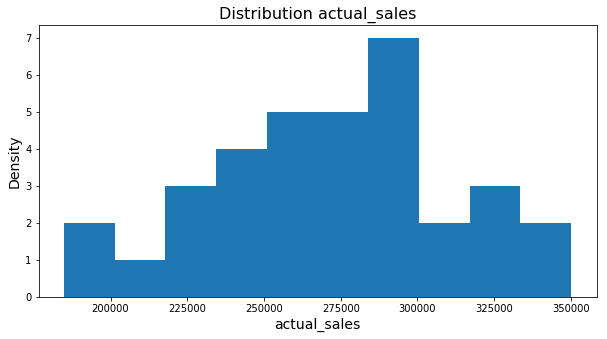

Mean: 271720.41
Median: 275268.7
Std.: 40037.63


Mean: 272658.08
Median: 271904.71
Std.: 36833.99


In [17]:
for feature in plot_features:
    plot_distribution(df=df_monthly, feature_col=feature)


#### Comments 


 - The mean values of the three variables are different. This shows that the sum of the daily sales reported to HQ may not exactly match the actuals of the full month.
 
    
  

### Actual sales and LO over time

In the following graph we observe the LO and actual sales variables during the period in analysis. 

In [18]:
# Set date as index
df_monthly.index=pd.DatetimeIndex(pd.to_datetime(df_monthly.Date))
df_monthly.sort_index(inplace=True)

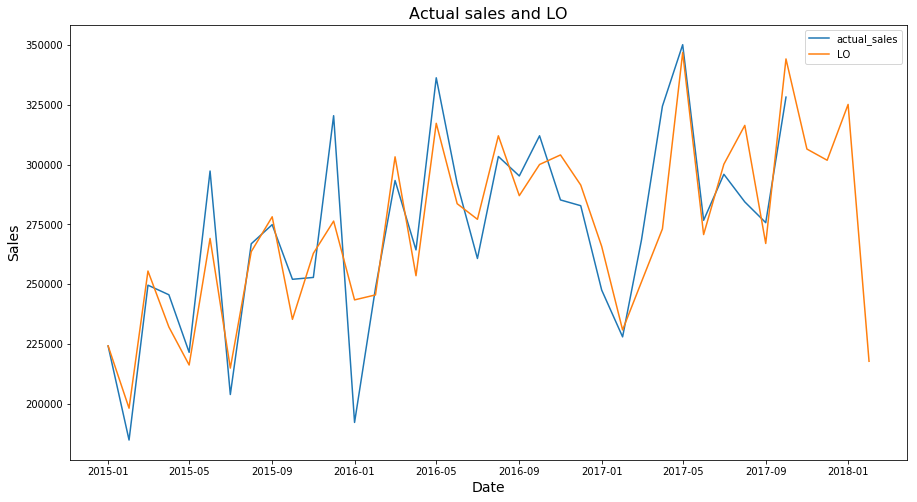

In [19]:
#Plot the actual sales and LO by month
fig = plt.figure(figsize=(15,8))
plt.plot(df_monthly.index, df_monthly['actual_sales'])
plt.plot(df_monthly.index, df_monthly['LO'])

plt.title('Actual sales and LO', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.legend()



### Daily sales plot

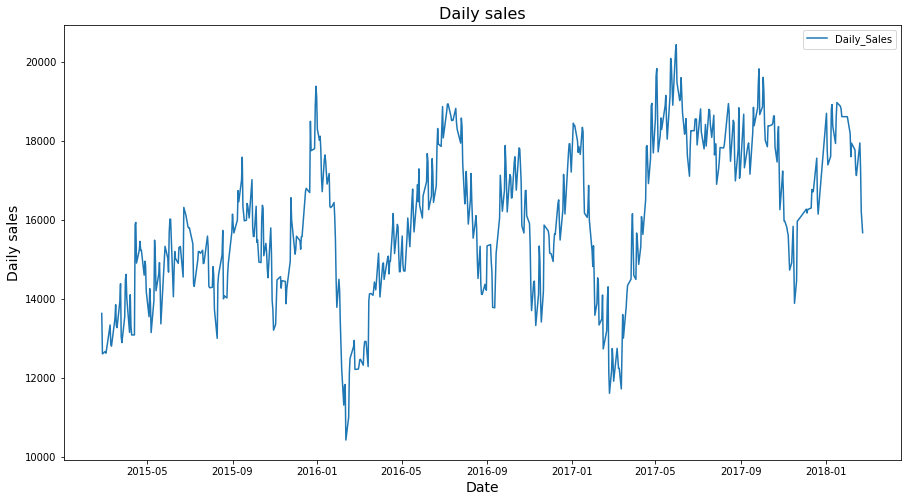

In [20]:
#Plot the actual sales and LO by month
fig = plt.figure(figsize=(15,8))
plt.plot(df_daily_sales.index, df_daily_sales['Daily_Sales'].rolling(window=30).mean())

plt.title('Daily sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Daily sales', fontsize=14)
plt.legend()



### Actual sales (variable to forecast)

In this step, I analyse our target variable (actual sales). Fisrt, I determine if the actual sales is a stationary variable and then I do some plots in order to see if we can find some seasonality or trend patterns.

#### - Determining Stationarity 

A stationary series is one where the values of the series is not a function of time.

We observe a plot of the actual sales and afterwards I perform the dickey fuller test in order to determine if the variable is stationary.

In [21]:
def time_plot(df, x_col, y_col, title):
    
    """
    Plot the feature over the time variable and show the mean of the last 6 months. 
    
    :param df: pandas dataframe including the feature and date
    :param x_col: column name of the date variable to be plotted
    :param y_col: column name of the variable to be plotted
    
    :return: graph of the timeseries and mean of the last sex months. 
    
    """
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=df, ax=ax, color='mediumblue', label='Total Sales')
    
    second = df.groupby(df[x_col].dt.year)[y_col].mean().reset_index()
    second.Date = pd.to_datetime(second.Date, format='%Y')
    sns.lineplot((second.Date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()

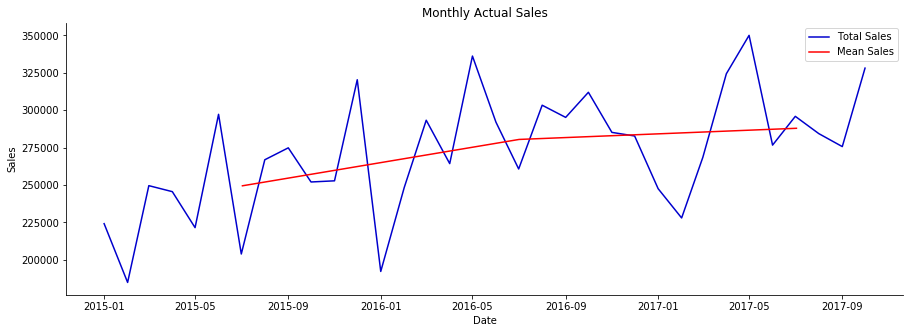

In [22]:
time_plot(df_monthly, 'Date', 'actual_sales', 'Monthly Actual Sales')


In [23]:
# Dicky -Fuller test to see if the actual sales is stacionary: 
result = adfuller(df_actual.actual_sales.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.431120824999581
p-value: 0.0002613689886279794
Critial Values:
   1%, -3.6461350877925254
Critial Values:
   5%, -2.954126991123355
Critial Values:
   10%, -2.6159676124885216


We reject the null hypothesis so montly actual sales is stationary (0.000026<0.05).

#### - Seasonality and trend

In [24]:
# Plotting seasonality and trend
def plot_timeseries(sales):
    
    """
    Plots of the trend and seasonality of the time serie. 
    
    :param sales: column name of the variable to be plotted
    
    :return: 2 graphs of the trend and seasonality of the time serie.
    
    """
    
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    decomposition= seasonal_decompose(sales, model = 'additive', freq=12)
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
        
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');
    plt.title('Decomposition Plots')

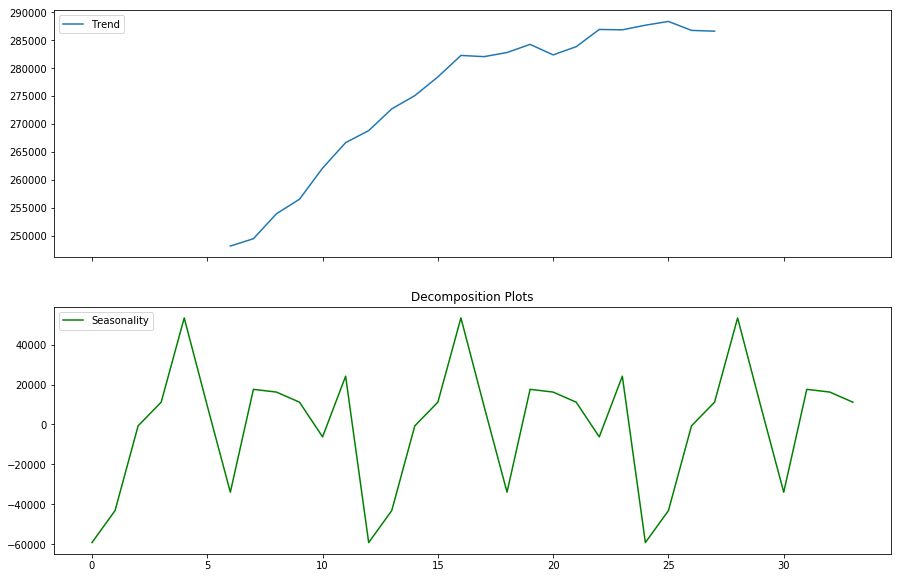

In [25]:
plot_timeseries(df_actual.actual_sales)

From the above plots, we can see that there are seasonality and trend present in our data. So, we’ll take into account these factors in the forecasting models.

#### - Autocorrelation 

The next step is to identify if the model needs any AR terms. We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags.

We can observe in the PACF graph that the first 14 lags are not significant, just lag 15, 17 and 18 are quite significant since they are well above the significance line. Therefore, in our model we won't include the lag terms of the actual sales.



In [26]:
def acf_pacf_plot(df, lags=None):
    
    """
    Plots of the serie over time, the autocorrelation and partial autocorrelation of the serie.
    
    :param df: pandas dataframe including the serie to plot 
    
    :return: 3 graphs with the serie over the time, the autocorrelation and partial autocorrelation of the serie. 
    
    """
    
    # Create dataframe just with actual sales and date as index
    dt_data = df.filter(['actual_sales'], axis=1)
    dt_data = dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

acf_pacf_plot(df_monthly, lags=24)

## 3. Data engineering for modelling

In this step, I create the dataframe with the required structure for the modelling step:
 
 - #### Merge the calendar dataframe with the daily sales df: 
     To create a column with the cumulative number of working days.
 
 - #### Prepare the data to create the dataframe to train and the datframe to predict for each prediction day (cutt_off_day): 
   Count the number of working days untill the prediction day (cutt_of_day).
   
   Create a variable of the sum of the daily sales untill the cutt_off_day for each month (daily_sales_trunc).
   
   Create a base dataframe where we include all the monthly variables and also the aggregated daily sales up untill the working day we want to make the prediction. (So for example if we want to predict the full month of November 2017 on Nov 15, we will consider as a variable the aggregated daily sales untill the correspondently number of working days for each month (in this case 10). 
   Create the ratio_work_day, ratio_daily_sales_trunc_LO and the monthly and yearly dummy variables to use them as predictors in the forecasting model.
   
   From the base dataframe, select the observations to create the dataframe to train the model
   
   From the base dataframe, select the observations to create the dataframa with the observations to predict.
   

#### The features included to fit the models are:

 - The number of working days of the month
 - The number of Monday, Tuesdays, Wednesday, Thursday and Friday in each month
 - The daily sales truncated (sum of daily sales untill the date of prediction).
 - The ratio of working days untill the cut off date (date of prediction) over the total number of working days of the month. 
 - The ratio of daily sales truncated over the total LO of the month.
 - Monthly dummies
 - Yearly dummies

### General Set-Up: 
In order to keep the steps clean and the code readable, I split the differetn steps into functions which are subsequently called. Furthermore, this makes it easier to adjusting certain parts and/or debugging


In [27]:
# Merge calendar df with daily sales df
df_daily_sales.reset_index(inplace=True)
df_calendar_daily = df_calendar.merge(df_daily_sales, how='left', on='Date')

# Sort values by date
df_calendar_daily.sort_values(by='Date', inplace=True)

# Create the cumulative working days variable
df_calendar_daily['cum_work_days'] = df_calendar_daily.groupby('Month_Year')['no_holiday'].transform('cumsum')

In [28]:
# Create a copy of the monthly dataframe 
df_monthly_full = df_monthly
# Replace the nan values of the actual sales for the 4 months we want to predict with the aggregated daily sales.
# We do this to run the model and to make the prediction of the months of Dec, Jan and Feb.
# When we do the prediction of Dec we already know the actual sales of the previous month.
df_monthly_full.actual_sales.fillna(df_monthly_full.agg_daily_sales, inplace=True)


In [29]:
def prep_data(df_daily, df_monthly, cut_off_date):
    
    """
    Function to create dataframes for training and prediction
    
    :param df_daily: pandas dataframe including the daily features (working days)
    :param df_monthly: pandas dataframe including the monthly features
    
    :return: df_to_train (data used for training), df_to_predict (data for monthly prediction)
    
    """
    
    # Define month and year of the correspondently cut_off_date for the prediction
    month = pd.to_datetime(cut_off_date).month
    year = pd.to_datetime(cut_off_date).year
    # Create temporary df with the rows of the daily df that coincide with the month and year of the cut_off_date
    df_tmp = df_daily[(df_daily.Month == month) & (df_daily.Year == year)]
    # Define the num of working days untill the cut_off_date
    working_days_to_use = df_tmp[df_tmp['Date']<cut_off_date].cum_work_days.max()
    
    
    #Truncate the daily df with just the working days to use define in the previous step
    df_truncated = df_daily[df_daily.cum_work_days<=working_days_to_use] 
    df_truncated.rename({'Daily_Sales': 'daily_sales_trunc'}, axis=1, inplace=True)
    #Aggregate and get the sum of the daily sales untill the working day we want to make the prediction
    df_agg = df_truncated.groupby(['Year', 'Month'])['daily_sales_trunc'].sum().reset_index() 
    
    
    # Create base dataframe (merge the aggregated df with the monthly df) 
    df_base = df_monthly.merge(df_agg, how='inner', on=['Year', 'Month'])
    # Create ratio of working days and ratio of the daily sales truncated over LO 
    df_base['ratio_work_days'] = working_days_to_use / df_base['Working_days'] 
    df_base['ratio_daily_sales_trunc_LO'] = df_base['daily_sales_trunc'] / df_base['LO'] 
    # Create dummy variables for the month
    df_base['Month_dummy'] = df_base['Month']
    df_base = pd.get_dummies(df_base, columns=['Month_dummy'], drop_first=True)
    # Create dummy variables for the year
    df_base['Year_dummy'] = df_base['Year']
    df_base = pd.get_dummies(df_base, columns=['Year_dummy'], drop_first=True)
    
    
    # Create dataframe to train the model 
    # Drop nan values (created from the lag actual sales)
    df_to_train = df_base.dropna().reset_index(drop=True)
    # Create Month_Year column
    df_to_train['Month_Year'] = pd.to_datetime(df_to_train['Date']).dt.to_period('M')
    # Select observation before the cutt_of day
    df_to_train = df_to_train[df_to_train['Month_Year'] < cut_off_date]
    # Drop extra columns
    df_to_train = df_to_train.drop(['agg_daily_sales','Month','Year','Month_Year'
                                    ,'LO','Sat','Sun','Total_Weekdays'], axis=1)
    
    # Create dataframe to predict 
    df_to_predict = df_base[(df_base.Month ==month) & (df_base.Year==year)]
    # Drop extra columns
    df_to_predict = df_to_predict.drop(['Month','Year','actual_sales'
                                       ,'LO','Sat','Sun','Total_Weekdays'], axis=1)
    
    return df_to_train, df_to_predict

## 4. Forecasting: Predictive Modelling

### Fit the predictive models 

Let’s sort out the steps to follow for building the predictive model:

- Define function to split a data set into target and features 

- Define list with the cut off dates we want to predict

- Define function to predict the new observations (different cut off dates)

- Run the previous function to get the predictions using different algorithms


### Select algorithms 

I will train three different algorithm: 

   - Linear Regression 
   
   - Random Forest
   
   - Gradient Boosting Regressor
   

These three models predict in different ways. First, the linear regression uses a linear approach to modeling the relationship between the response (or dependent variable) with the explanatory variables. Random Forest Regressions is a tree model and a non parametric approach where it grows multiple independent decisions trees and it choses as output the mean prediction over all the trees. Gradient Boosting Regressor is also a non parametric approach which first fits simple models several times, each time focusing on those data points hard to fit to get them right.



In [30]:
def split_features(df, date_col, target_col):
    
    """
    Function to split a data set in features and target variable 
    
    :param df: pandas dataframe including the features to fit the models
    :param date_col: date variable name
    :param sales_cole: target variable name
    :return: 2 arrays X (with the features) and y (with the target variable).
    
    """
    
    X = np.array(df.drop([date_col, target_col],axis=1))
    y = np.array(df[[target_col]])
    
    return X, y

In [31]:
cut_off_dates= ['2017-11-15','2017-11-16', '2017-11-17','2017-11-20','2017-11-21','2017-11-22'
                ,'2017-12-15','2017-12-18','2017-12-19','2017-12-20','2017-12-21','2017-12-22'
                ,'2018-01-15', '2018-01-16','2018-01-17','2018-01-18','2018-01-19','2018-01-22'
                ,'2018-01-23','2018-01-24','2018-01-25'
                ,'2018-02-15','2018-02-16','2018-02-19','2018-02-20','2018-02-21','2018-02-22','2018-02-23']

In [32]:
def make_final_prediction(df_daily, df_monthly, cut_off_date, model):
    
    """
    Function to make the prediction of the cut_off_date
    
    :param df_daily: pandas dataframe including the daily features (working days)
    :param df_monthly: pandas dataframe including the monthly features
    :param cutt_off_date: date to make the prediction
    :param model: algorithm to fit
    
    :return: y_pred (prediction of the model), y_new (actual values) and the date of the prediction
    
    """
    df_to_train, df_to_predict  = prep_data(df_daily, df_monthly, cut_off_date)
    
    X_to_train, y_to_train = split_features(df_to_train, 'Date', 'actual_sales')
    
    X_new, y_new = split_features(df_to_predict, 'Date', 'agg_daily_sales')
    
    mod = model
    mod.fit(X_to_train, y_to_train)
    y_pred = mod.predict(X_new)[0]
    
    return (y_pred, y_new[0][0], cut_off_date)
    

In [33]:
def get_final_predictions(df_daily, df_monthly, cut_off_dates_list, model):
    
    """
    Funtion to get the prection of the traget variable for all the cutting dates of of the cut_off_dates_list
    
    :param df_daily: pandas dataframe including the daily features (working days)
    :param df_monthly: pandas dataframe including the monthly features
    :param cutt_off_date: date to make the prediction
    :param model: algorithm to fit
    
    :return: dataframe with the predictions of a model for each cut off date of the cut_off_dates_list and the error metrics for each preditcion. 
    
    """
    results_list=[]

    for cut_off_date in cut_off_dates_list: 

        results_list.append(make_final_prediction(df_daily, df_monthly, cut_off_date, model))

    # Create a df from the previous list with the prredictions and actual sales for each cut day
    df_results = pd.DataFrame(results_list, columns = ['pred', 'actual', 'cut_date'])
    # Create the absolute, square and relative error for each prediction
    df_results['abs_error'] = np.abs(df_results['pred'] - df_results['actual'])
    df_results['square_error'] = df_results['abs_error']**2
    df_results['rel_error'] = np.abs((df_results['pred'] - df_results['actual'])/ df_results['actual']*100)
    
    return df_results

In [34]:
# Apply the function get_final_predictions for the three selected algorithms.
df_results_lr = get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates, LinearRegression())
df_results_rf = get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates,  RandomForestRegressor(n_estimators=100, random_state = 123))
df_results_gb = get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates, GradientBoostingRegressor())


## 4. Select final model

To select the model for the predictions of the different cut dates of the 4 momths (Nov, Dec, Jan and Feb), I created a function that returns the Mean Absolute Error (MAE), Mean Square Error (MSE), Mean Relative Error (MRE) and Root Mean Square Error (RMSE). 

Then, I compared these score metrics among the fitted models. 

Finally, I selected the model with the lowest scores.    

In [35]:
# Define dictionary with the model names and dataframes with the prediction results
model_df_dict = {'models': ['Linear Regression','Random Forest','Gradient Boosting']
                 , 'model_dfs': [df_results_lr, df_results_rf, df_results_gb]}

In [36]:
def show_model_errors(model_df_dict, actual, pred, rel_error):
    
    """
    Function to get the mean score metrics of the different fitted models.
    
    :param model_df_dict: dictinoary with the fitted model names and the the df with the predictions of each model.
    :param actual: column name of the actual values
    :param pred: column name of the predicted values
    :param rel_error: column names of the relative error
    
    :return: dataframe with the mean score metrics of the different fitted models.
    
    """
        
    list_mae = []
    list_mse = []
    list_mre = []
    
    for model_df in model_df_dict['model_dfs']:
    
    # List of the mean absolute error of each model that is to be converted into a column 
        MAE = metrics.mean_absolute_error(model_df[actual], model_df[pred])
        list_mae.append(MAE)
    
    # List of the mean square error of each model that is to be converted into a column 
        MSE = metrics.mean_squared_error(model_df[actual], model_df[pred])
        list_mse.append(MSE)

    # List of the mean relative error of each model that is to be converted into a column 
        MRE = model_df[rel_error].mean()
        list_mre.append(MRE)
        
    df_scores = pd.DataFrame(list(zip(model_df_dict['models'], list_mae, list_mse, list_mre))
                             , columns =['model','MAE', 'MSE','MRE'])
    
    # Calculate the root mean square error
    df_scores['RMSE'] = np.sqrt(df_scores['MSE'])
    
    return df_scores

In [37]:
df_model_scores=show_model_errors(model_df_dict, 'actual', 'pred', 'rel_error')
df_model_scores

model           MAE           MSE                  MRE  \
0  Linear Regression  59354.448043  4.842135e+09  [28.58130328491856]   
1      Random Forest  56866.658619  3.646391e+09              27.4727   
2  Gradient Boosting  62923.684413  4.673075e+09              29.5199   

           RMSE  
0  69585.449480  
1  60385.356732  
2  68359.890492

The dataframe shows the different metrics for the fitted models. We will use the Random Forest model for the final prediction for each cut date because the MAE, MSE, and RMSE are the lowest among the 3 models.

## 5. Build a measure for the confidence of this forecast

In the last step, I fitted the random forest model previously selected for the previous 6 months for each month we want to make the prediction (Nov, Dec, Jan and Feb). When fitting the models I considered all the cut off dates (working days between the 15th and 25th) of each month.

Afterwards, I calculated the mean relative error (MRE) for each of the target months. For example, for the predictions in November I used the MRE of the previous 6 months (May, Jun, Jul, Ago, Sep and Oct) as a measure for the confidence of the forecast.

Finally, I created a function to calculate the upper and lower error margin using the correspondently mean realative error (MRE) in each month. 


In [38]:
# Define 4 list for the 4 different months we made the predictions (Nov, Dec, Jan and Feb). 
# The lists include the correspondently cut off dates of the previous 6 months 
# cut off dates: working days between the 15th- 25th of each month) 

cut_off_dates_ci_nov= ['2017-05-15','2017-05-16','2017-05-17','2017-05-18','2017-05-19','2017-05-22'
                       ,'2017-05-23','2017-05-24','2017-05-25'
                       ,'2017-06-15','2017-06-16','2017-06-19','2017-06-20','2017-06-21','2017-06-22'
                       ,'2017-06-23'
                       ,'2017-07-17','2017-07-18','2017-07-19','2017-07-20','2017-07-21','2017-07-24'
                       ,'2017-07-25'
                       ,'2017-08-15','2017-08-16','2017-08-17','2017-08-18','2017-08-21','2017-08-22'
                       ,'2017-08-23','2017-08-24','2017-08-25'
                       ,'2017-09-15','2017-09-18', '2017-09-19','2017-09-20','2017-09-21','2017-09-22'
                       ,'2017-09-25'
                       ,'2017-10-16','2017-10-17','2017-10-18','2017-10-19','2017-10-20','2017-10-23'
                       ,'2017-10-24','2017-10-25']

cut_off_dates_ci_dec= ['2017-06-15','2017-06-16','2017-06-19','2017-06-20','2017-06-21','2017-06-22'
                       ,'2017-06-23'
                       ,'2017-07-17','2017-07-18','2017-07-19','2017-07-20','2017-07-21','2017-07-24'
                       ,'2017-07-25'
                       ,'2017-08-15','2017-08-16','2017-08-17','2017-08-18','2017-08-21','2017-08-22'
                       ,'2017-08-23','2017-08-24','2017-08-25'
                       ,'2017-09-15','2017-09-18', '2017-09-19','2017-09-20','2017-09-21','2017-09-22'
                       ,'2017-09-25'
                       ,'2017-10-16','2017-10-17','2017-10-18','2017-10-19','2017-10-20','2017-10-23'
                       ,'2017-10-24','2017-10-25'
                       ,'2017-11-15','2017-11-16', '2017-11-17','2017-11-20','2017-11-21','2017-11-22']

cut_off_dates_ci_jan= ['2017-07-17','2017-07-18','2017-07-19','2017-07-20','2017-07-21','2017-07-24'
                       ,'2017-07-25'
                       ,'2017-08-15','2017-08-16','2017-08-17','2017-08-18','2017-08-21','2017-08-22'
                       ,'2017-08-23','2017-08-24','2017-08-25'
                       ,'2017-09-15','2017-09-18', '2017-09-19','2017-09-20','2017-09-21','2017-09-22'
                       ,'2017-09-25'
                       ,'2017-10-16','2017-10-17','2017-10-18','2017-10-19','2017-10-20','2017-10-23'
                       ,'2017-10-24','2017-10-25'
                       ,'2017-11-15','2017-11-16', '2017-11-17','2017-11-20','2017-11-21','2017-11-22'
                       ,'2017-12-15','2017-12-18','2017-12-19','2017-12-20','2017-12-21','2017-12-22']

cut_off_dates_ci_feb= ['2017-08-15','2017-08-16','2017-08-17','2017-08-18','2017-08-21','2017-08-22'
                       ,'2017-08-23','2017-08-24','2017-08-25'
                       ,'2017-09-15','2017-09-18', '2017-09-19','2017-09-20','2017-09-21','2017-09-22'
                       ,'2017-09-25'
                       ,'2017-10-16','2017-10-17','2017-10-18','2017-10-19','2017-10-20','2017-10-23'
                       ,'2017-10-24','2017-10-25'
                       ,'2017-11-15','2017-11-16', '2017-11-17','2017-11-20','2017-11-21','2017-11-22'
                       ,'2017-12-15','2017-12-18','2017-12-19','2017-12-20','2017-12-21','2017-12-22'
                       ,'2018-01-15', '2018-01-16','2018-01-17','2018-01-18','2018-01-19','2018-01-22'
                       ,'2018-01-23','2018-01-24','2018-01-25']


In [39]:
# Apply the get_final_predictions for the 4 months in order to get the mean scores errors of the 6 previous months to builf the confidence interval of each prediction.
df_rf_ci_nov = get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates_ci_nov, RandomForestRegressor(n_estimators=100, random_state = 123))
df_rf_ci_dec= get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates_ci_dec, RandomForestRegressor(n_estimators=100, random_state = 123))
df_rf_ci_jan = get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates_ci_jan, RandomForestRegressor(n_estimators=100, random_state = 123))
df_rf_ci_feb = get_final_predictions(df_calendar_daily, df_monthly_full, cut_off_dates_ci_feb, RandomForestRegressor(n_estimators=100, random_state = 123))


In [40]:
# Dictionary with the months and df with the results of the models to build the measures of the confidence of the forecast.
months_df_dict = {'months': ['2017-11', '2017-12','2018-01','2018-02']
                             , 'months_dfs': [df_rf_ci_nov, df_rf_ci_dec, df_rf_ci_jan, df_rf_ci_feb]}
                            

In [41]:
def get_error_measures(months_df_dict, actual, pred, rel_error):
    
    """
    Function to get the mean score metrics of the different fitted models to build the measure of confidence of the forecast.
    
    :param months_df_dict: dictinoary with the month and the df with the predictions of the 6 previous months
    :param actual: column name of the actual values
    :param pred: column name of the predicted values
    :param rel_error: column names of the relative error
    
    :return: dataframe with the mean score metrics of the 6 previous months for nov, dec, jan and feb.
    
    """
        
    list_mae = []
    list_mse = []
    list_mre = []
    
    
    for month_df in months_df_dict['months_dfs']:
    
    # List of the mean absolute error of each model that is to be converted into a column 
        MAE = metrics.mean_absolute_error(month_df[actual], month_df[pred])
        list_mae.append(MAE)
    
    # List of the mean square error of each model that is to be converted into a column 
        MSE = metrics.mean_squared_error(month_df[actual], month_df[pred])
        list_mse.append(MSE)

    # List of the mean relative error of each model that is to be converted into a column 
        MRE = month_df[rel_error].mean()
        list_mre.append(MRE)
    
        
    df_scores = pd.DataFrame(list(zip(months_df_dict['months'], list_mae, list_mse, list_mre))
                             , columns =['month_year','MAE', 'MSE','MRE'])
    
    
    return df_scores

In [42]:
# Apply the get_error_measures to get the MRE
df_errors= get_error_measures(months_df_dict, 'actual', 'pred', 'rel_error')

#### Confidence interval for the predictions using the Mean Relative Error (MRE) of the 6 previous months predictions 

In [43]:
def get_error_bounds(df_predictions, df_error):
    
    """
    Function to show the predictions and calculate low and up error margins for each cut off date.
    
    :param df_predictions: pandas dataframe including the predictions of the selected model for each cut off date.
    :param df_error: pandas dataframe including the MRE of the 6 previous months for the months we made the prediction.
    
    :return: dataframe with the predictions and lower and upper error margins for each cut off date.
    
    """
    
    df_pred = df_predictions.copy()
    df_re = df_error.copy()
    
    df_pred['month_year'] = pd.to_datetime(df_pred['cut_date']).dt.to_period('M').astype(str)
    #df_rmsq['month_year'] = pd.to_datetime(df_rmsq['month_year']).dt.to_period('M')
    
    df_final = pd.merge(df_pred[['pred','cut_date','month_year']], df_re[['MRE','month_year']], on='month_year', how='left')
    df_final['error_margin_low'] = df_final['pred'] *(1 - df_final['MRE']/100)
    df_final['error_margins_high'] = df_final['pred'] * (1 + df_final['MRE']/100)

    
    return df_final

In [44]:
# Apply the build_ci function to get the measures of confidence for the prediction in each cut off date.
df_final_pred = get_error_bounds(df_results_rf, df_errors)
df_final_pred.head(30)

pred    cut_date month_year        MRE  error_margin_low  \
0   287981.322000  2017-11-15    2017-11   6.208548     270101.862420   
1   266609.030000  2017-11-16    2017-11   6.208548     250056.479500   
2   260789.776000  2017-11-17    2017-11   6.208548     244598.516697   
3   259586.618000  2017-11-20    2017-11   6.208548     243470.057343   
4   274352.032000  2017-11-21    2017-11   6.208548     257318.753478   
5   311345.424000  2017-11-22    2017-11   6.208548     292015.392854   
6   290114.864037  2017-12-15    2017-12   7.823520     267417.669398   
7   315535.961019  2017-12-18    2017-12   7.823520     290849.941752   
8   298446.443056  2017-12-19    2017-12   7.823520     275097.425659   
9   297229.463056  2017-12-20    2017-12   7.823520     273975.656333   
10  282929.711056  2017-12-21    2017-12   7.823520     260794.648302   
11  282626.699130  2017-12-22    2017-12   7.823520     260515.342576   
12  306188.164000  2018-01-15    2018-01  12.459944     268037.291498   
13  292687.356791  2018-01-16    2018-01  12.459944     256218.677250   
14  311366.068000  2018-01-17    2018-01  12.459944     272570.031580   
15  321124.864000  2018-01-18    2018-01  12.459944     281112.887104   
16  328596.228000  2018-01-19    2018-01  12.459944     287653.323364   
17  324995.764000  2018-01-22    2018-01  12.459944     284501.475148   
18  307961.844112  2018-01-23    2018-01  12.459944     269589.972068   
19  322386.120000  2018-01-24    2018-01  12.459944     282216.991318   
20  323743.224000  2018-01-25    2018-01  12.459944     283405.000925   
21  211753.134000  2018-02-15    2018-02  14.204344     181674.989780   
22  200018.389019  2018-02-16    2018-02  14.204344     171607.088379   
23  199713.974074  2018-02-19    2018-02  14.204344     171345.913581   
24  226108.762726  2018-02-20    2018-02  14.204344     193991.495576   
25  214268.579843  2018-02-21    2018-02  14.204344     183833.133035   
26  220167.838112  2018-02-22    2018-02  14.204344     188894.440348   
27  213270.645056  2018-02-23    2018-02  14.204344     182976.948341   

    error_margins_high  
0        305860.781580  
1        283161.580500  
2        276981.035303  
3        275703.178657  
4        291385.310522  
5        330675.455146  
6        312812.058677  
7        340221.980285  
8        321795.460453  
9        320483.269778  
10       305064.773809  
11       304738.055685  
12       344339.036502  
13       329156.036331  
14       350162.104420  
15       361136.840896  
16       369539.132636  
17       365490.052852  
18       346333.716155  
19       362555.248682  
20       364081.447075  
21       241831.278220  
22       228429.689658  
23       228082.034568  
24       258226.029876  
25       244704.026651  
26       251441.235875  
27       243564.341771

## 6. Final results and future improvements

The main goal of this excersise was to give the full month prediction of November 2017, December 2017, January 2018 and February 2018b in the different cut off dates to help the HQ to know in advance what the actual sales will be. And also to build a measure to indicate the confidence of each forecsat. 

By using the prediction model the HQ could know in advance the montly sales of the next month with a certein level of confidence of each prediction and take apporpiate actions.

The approach that I followed in this excercise is one of the possible ways to do it. As well, we could use other algorithms to fit the model. 

Another way of doing this analysis could be to fit the different algorithms splitting the observations in training and test set before Nov 2017. However, in the present analysis I used as the test set the months of Nov, Dec, Jan and Feb and I used as the total sales of the month the sum of the daily sales to test the performance of the models.

Regarding the measurement of the confidence of the forecast, another approach could be to estimate the upper and lower confidence intervals using the RMSE as an approximation of the standard deviation of the error. For this the forecast errors should be normally distributed and a larger sample would be required.
